In this notebook, we compare antenna temperatures for our different feeds. The antenna temperature is given by 
\begin{equation}
T_A=\frac{\int d\Omega P(\theta,\phi) T(\theta,\phi) }{\int d \Omega P(\theta,\phi)}
\end{equation}

In [148]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from pygsm import GSMObserver
from datetime import datetime
import healpy as hp
from astropy.io import fits
import scipy.interpolate as interp
PLOTDIR='/Users/ewallwic/Dropbox_MIT/Science/simulations-hera-eox/analysis/vivaldi_sensitivity/'

In [113]:
#load fits beams
vivaldifile='/Users/ewallwic/Dropbox_MIT/Science/simulations-hera-eox/data/simulations/Vivaldi_Beams/Vivaldi-Gain.fits'
vivaldiints='Vivaldi-Gain_integrals.npy'
herafile='/Users/ewallwic/Dropbox_MIT/Science/simulations-hera-eox/data/simulations/Beams_HighBand/beamSouthAfricaFeedOverDish.fits'
heraints='beamSouthAfricaFeedOverDish_integrals.npy'


Here is a function that reads in a prisim formatted fits file and computes the antenna temperature using the GSM as a function of time and frequency. 

In [104]:
def skytemps(fitsfile,latitude='-30.7216391',longitude='21.4110768',altitude=1054,dh=1.,year=2018,month=1,day=1):
    nhours=int(np.round(24./dh))
    hours=np.linspace(0,24,nhours,endpoint=False)
    ov = GSMObserver()
    ov.lon = longitude
    ov.lat = latitude
    ov.elev = elevation
    fitshdu=fits.open(fitsfile)
    freqs=fitshdu[1].data
    beamdata=fitshdu[2].data
    npixbeam=beamdata.shape[0]
    nsidebeam=hp.npix2nside(npixbeam)
    nfreqs=beamdata.shape[1]
    temps=np.zeros((nhours,nfreqs))
    rotator=hp.Rotator(rot=(0,90,180))
    thetab,phib=hp.pix2ang(nsidebeam,range(npixbeam))
    newthetab,newphib=rotator(thetab,phib)
    for hnum,hour in enumerate(hours):
        h=int(hour)
        m=int((hour-int(hour))/60.)
        ov.date=datetime(year,month,day,h,m)
        for fnum,freq in enumerate(freqs):    
            beamslice=hp.get_interp_val(beamdata[:,fnum],newthetab,newphib)
            skymap=ov.generate(freq/1e6)
            nsidesky=hp.npix2nside(len(skymap))
            theta,phi=hp.pix2ang(nsidebeam,range(npixbeam))
            skymap_interp=hp.get_interp_val(skymap,theta,phi)
            temps[hnum,fnum]=np.sum(skymap_interp*beamslice)/np.sum(beamslice)
    return hours,freqs,temps,interp.RectBivariateSpline(hours,freqs/1e6,temps)

In [83]:
np.linspace(0,24,24,endpoint=False)

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.])

In [112]:
h_vivaldi,f_vivaldi,t_vivaldi,t_vivaldi_spline=skytemps(vivaldifile,dh=1)

In [114]:
np.savez('vivaldi_tant.npy',hours=h_vivaldi,freqs=f_vivaldi,tants=t_vivaldi)

First we plot the antenna temperature of the Vivaldi feed as a function of hour and frequency.

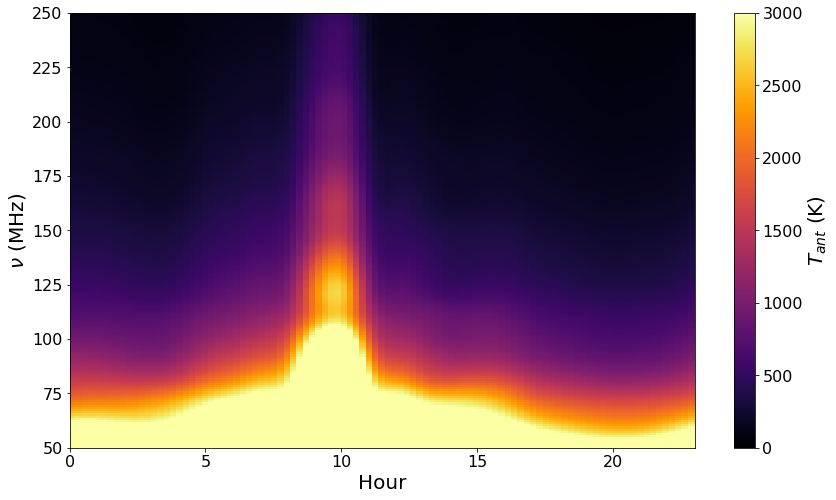

In [136]:
hg,fg=np.meshgrid(np.linspace(0,23,100),np.linspace(50,250,200))
plt.pcolor(hg,fg,t_vivaldi_spline.ev(hg,fg),vmin=0,vmax=3000,cmap='inferno')
cb=plt.colorbar()
cb.set_label(label='$T_{ant}$ (K)',fontsize=20)
cb.ax.tick_params('y',labelsize=16)
plt.xlabel('Hour',fontsize=20)
plt.ylabel('$\\nu$ (MHz)',fontsize=20)
plt.gcf().set_size_inches(14,8)
plt.gca().tick_params('x',labelsize=16)
plt.gca().tick_params('y',labelsize=16)
plt.savefig(PLOTDIR+'vivaldi_ant_temp.pdf')

Next we plot the logarithm of antenna temperature (for better dynamic range).

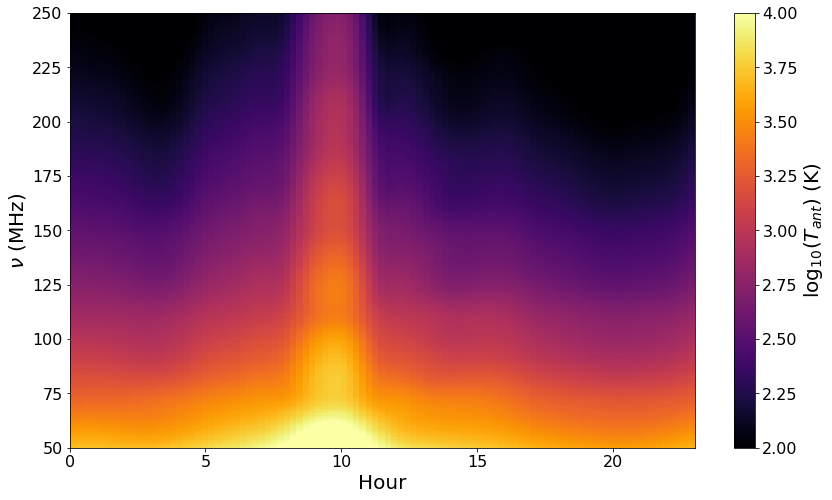

In [138]:
hg,fg=np.meshgrid(np.linspace(0,23,100),np.linspace(50,250,200))
plt.pcolor(hg,fg,np.log10(t_vivaldi_spline.ev(hg,fg)),vmin=2,vmax=4,cmap='inferno')
cb=plt.colorbar()
cb.set_label(label='log$_{10}(T_{ant})$ (K)',fontsize=20)
cb.ax.tick_params('y',labelsize=16)
plt.xlabel('Hour',fontsize=20)
plt.ylabel('$\\nu$ (MHz)',fontsize=20)
plt.gcf().set_size_inches(14,8)
plt.gca().tick_params('x',labelsize=16)
plt.gca().tick_params('y',labelsize=16)
plt.savefig(PLOTDIR+'vivaldi_ant_log_temp.pdf')

Most sensitivity calculations assume that the sky-temperature goes as 
\begin{equation}
T_\text{sky}=60 \lambda^{2.55} \text{K}
\end{equation}
It is useful to compare the antenna temperature to this quantity to see how much this estimate will overpredict or underpredict the actual antenna temperature. Below, we take the ratio of the antenna temperature and the sky-temperature assumed in sensitivity calculations. Pleasantly enough, the sky temperature has roughly the same amplitude (sometimes significantly lower) for many LSTs. 

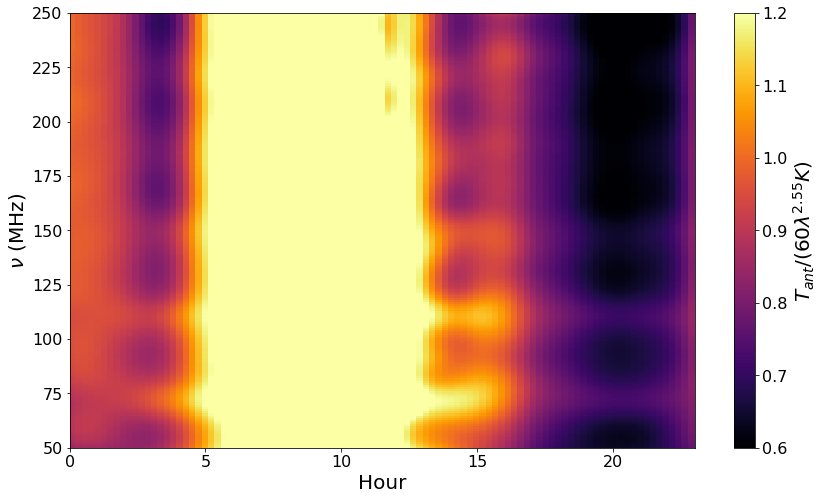

In [146]:
hg,fg=np.meshgrid(np.linspace(0,23,100),np.linspace(50,250,200))
plt.pcolor(hg,fg,t_vivaldi_spline.ev(hg,fg)/(60.*(300/fg)**2.55),vmin=.6,vmax=1.2,cmap='inferno')
cb=plt.colorbar()
cb.set_label(label='$T_{ant}/(60 \lambda^{2.55} K)$ ',fontsize=20)
cb.ax.tick_params('y',labelsize=16)
plt.xlabel('Hour',fontsize=20)
plt.ylabel('$\\nu$ (MHz)',fontsize=20)
plt.gcf().set_size_inches(14,8)
plt.gca().tick_params('x',labelsize=16)
plt.gca().tick_params('y',labelsize=16)
plt.savefig(PLOTDIR+'vivaldi_sky_ratio.pdf')

To approximate out how inverse noise averaging in LST behaves, we average over LST weights of $1/T_{ant}^2$. The antenna temperature performs very closely to the theoretical model. The effecitive antenna temperature does not cause sensitivity to decrease relative to the theoretical predictions in the literature.

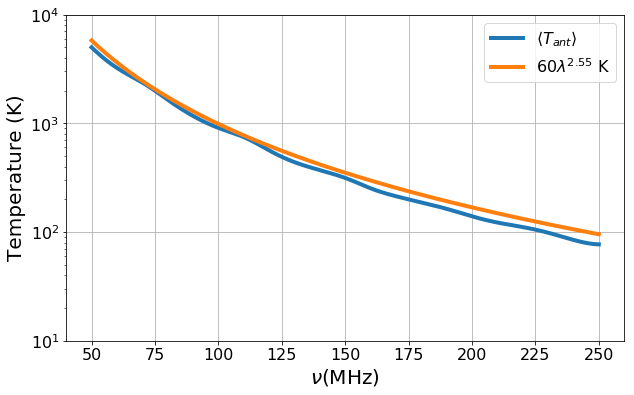

In [160]:
faxis=np.linspace(50,250,200)
hg,fg=np.meshgrid(np.linspace(0,23,100),faxis)
tg=t_vivaldi_spline.ev(hg,fg)
tg_avg=np.sum(tg/tg**2.,axis=1)/np.sum(1./tg**2.,axis=1)
plt.plot(faxis,tg_avg,label='$\\langle T_{ant}\\rangle$',lw=4)
plt.plot(faxis,60*(300/faxis)**2.55,label='$60 \lambda^{2.55}$ K',lw=4)
plt.xlabel('$\\nu$(MHz)',fontsize=20)
plt.ylabel('Temperature (K)',fontsize=20)
plt.yscale('log')
plt.legend(loc='best',fontsize=16)
plt.ylim(1e1,1e4)
plt.grid()
plt.gcf().set_size_inches(10,6)
plt.gca().tick_params('x',labelsize=16)
plt.gca().tick_params('y',labelsize=16)
plt.savefig(PLOTDIR+'tant_1d.pdf',bbox_inches='tight')

In [62]:
#latitude,longitude,elevation for HERA
(latitude, longitude, elevation) = ('-30.7216391', '21.4110768', 1054)
ov = GSMObserver()
ov.lon = longitude
ov.lat = latitude
ov.elev = elevation
ov.date = datetime(2018, 1, 1, 14, 0)
print freq_array.shape
d=ov.generate(freq_array[0])
theta,phi=hp.pix2ang(64,range(vivhdu[2].data.shape[0]))
dds=hp.get_interp_val(d,theta,phi)

(20,)


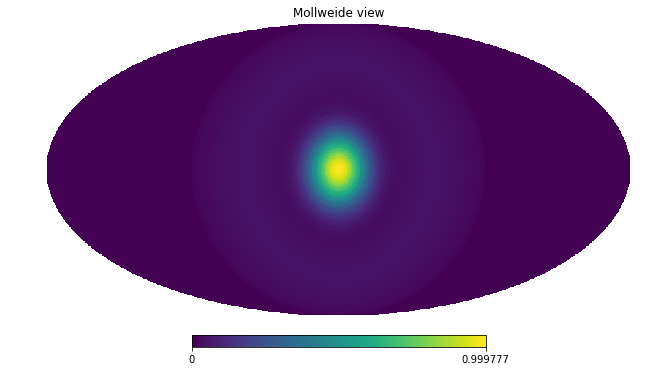

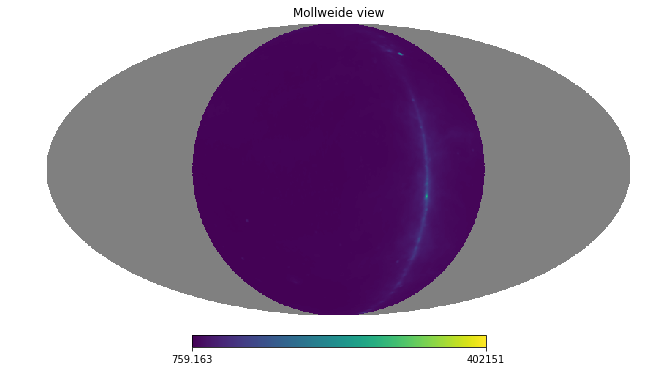

In [60]:
hp.mollview(vivdata)
hp.mollview(d)